An overview of the common zero-dimensional SEI models: 

Zero-dimensional growth models neglect most of the complexity of the SEI and instead model a single 'limiting' mechanism (e.g., diffusion of a single species). Without considering any other degradation mechanisms, the total current density is given by:

$$J_\mathrm{tot} = J_\mathrm{int} + J_\mathrm{SEI},$$
where $J_\mathrm{int}$ is the intercalation current density (usually described by the Butler-Volmer equation), and $J_\mathrm{SEI}$ represents the capacity fade proportional to the SEI thickness growth. Different $J_\mathrm{SEI}$ expressions are derived or proposed for different limiting mechanisms

Common Zero-dimenional models:

1. Reaction Limited: $J_\mathrm{SEI} = - j_{{SEI},0} \exp \left ( -\alpha_n \frac{F}{RT} \eta_{SEI} \right )$

2.  Electron Migration Limited: $J_\mathrm{SEI}=\frac{\sigma_{SEI} \eta_{SEI}}{L_{SEI}}$

3. Interstitial Diffusion Limited: $ J_\mathrm{SEI} = - \frac{F D_\mathrm{Li}}{L_\mathrm{SEI}} C_\mathrm{Li}\exp \left ( -\alpha_n \frac{F}{RT} \Delta \phi \right )$
    
4. Solvent Diffusion limited: $ J_\mathrm{SEI}=-\frac{-D_{sol} c_{sol} F}{L_{SEI}} $
5.  EC reaction Limited $ J_\mathrm{SEI}= -F k_{\mathrm{sei,0}} C_\mathrm{EC} \exp \left ( -\alpha_n \frac{F}{RT} \eta_{SEI} \right ), \ \ D_\mathrm{EC} \frac{C_\mathrm{EC}- C_\mathrm{EC}^0}{L_\mathrm{SEI}} = \frac{J_\mathrm{SEI}}{F} $


1. Different C Rate. Done
2. At which volatge J_SEI maximum? Done
2. Does relaxtion between charge and dicharge impact SEI? 
3. Tempreture
5. How charging, dis charging and rest differe the LSE:



<div class="alert alert-block alert-danger">
Don't run all the cells at once as it may take a long time. Each cell is independently designed for a specific output.
</div>

In [8]:
%cd /home/kawamanmi/Projects/PyBaMM
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Different set of parameters can be used in pybamm
param = pybamm.ParameterValues("Chen2020")

param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12


# CHarging and discharging protocol
cycle_no = 5
c_rates = [5, 10, 30, 50]
rest1 = 10
rest2 = 10
exp_CCCVs = [pybamm.Experiment(
    [("Charge at C/{} until 4.2 V".format(c_rate),
      "Rest for {} hours".format(rest1),
      "Discharge at C/{} until 2.5 V".format(c_rate),
      "Rest for {} hours".format(rest2),
      )] * cycle_no
)for c_rate in c_rates]

# SEI models in the pybamm
sei_models = ["ec reaction limited", "reaction limited",
              "solvent-diffusion limited", "interstitial-diffusion limited", "electron-migration limited"]
sei_models_Label = ["EC-RL", "RL", "S-DL", "I-DL", "E-ML"]


#Any common model DFN, SPMe, or SPM can be used the produce same results at low C-rates
models_SPM = [pybamm.lithium_ion.SPM(options={
    "SEI": sei_models[index],
     "SEI porosity change": "false",
},
    name=sei_models[index]) for index in range(len(sei_models))
]

# You may need to increase maximum number steps as follows:
pybamm.settings.max_y_value = 1000000000
solver = pybamm.CasadiSolver(mode="safe")
# solver = pybamm.IDAKLUSolver()
sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp_CCCV, solver=solver) for model in models_SPM for exp_CCCV in exp_CCCVs ]
sols = [sim.solve(initial_soc=0) for sim in sims]


/home/kawamanmi/Projects/PyBaMM


SEI thickness at each C-rate (along teh whoel battery life) to the maximum SEI thickness. Then plot L* vs cycle number

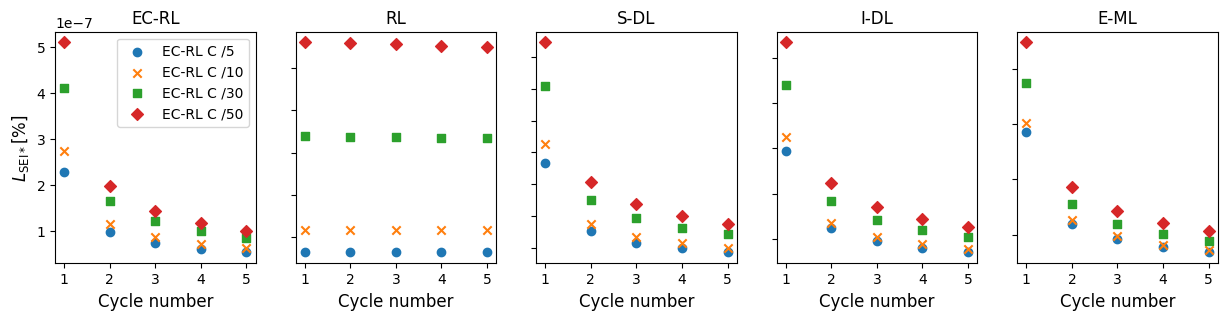

In [25]:
# Create 1 row and 5 columns of subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
k = 0
line_style = ["-", ":", "--", "-.", "-", ":"]
marker = ["o", "x", "s", "D", "v", "p"]
for i, model in enumerate(sei_models):
    for c_rate in (c_rates):
        LL = []
        max_y = 0
        LL_max = np.max(
            sols[k]['X-averaged negative total SEI thickness [m]'].entries)
        for cycle in range(cycle_no):
            t = sols[k].cycles[cycle]["Time [h]"].entries
            t_max = 1
            L_sei = sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries
            LL.append((np.max(L_sei))-np.min(L_sei))
        axs[i].scatter(np.arange(1, cycle_no+1, 1), LL, marker=marker[c_rates.index(
            c_rate)], label=sei_models_Label[sei_models.index(model)] + " C /" + str(c_rate))
        k += 1
        max_y = np.max(LL, max_y)
    axs[i].set_xticks(np.arange(1, cycle_no+1, 1))
    # axs[i].set_ylim([0, 0.5])  # Set y-axis limits
    # axs[i].set_yticks(np.linspace(0, 0.5, 6))  # Set y-axis ticks
    axs[i].set_title(sei_models_Label[i], fontsize=12)
    if i != 0:  # Remove y-axis labels for all but the first subplot
        axs[i].set_yticklabels([])
    axs[i].set_xlabel("Cycle number", fontsize=12)
    if i == 0:  # Only set y-label for the first subplot
        axs[i].set_ylabel('$L_{\mathrm{SEI*}} [\%]$', fontsize=12)
        axs[i].legend()
fig.savefig('/home/kawamanmi/Projects/formation/figure1{}.svg'.format(model.capitalize()),
            format='svg', dpi=300, bbox_inches='tight')
plt.show()

These plots compare the SEI thickness in cycles 1 and 2 for different SEI models at different C-rates.

Note: the L_sei and time for each cycle are shifted to start from zero.

Observations:
- In EC-RL:
- In RL, L_sei in cycles 1 and 2 does not change with C-rate
- In S-DL, surprisingly the trend of L_sei is the same for all C-rates in the first cycle, but not in the second cycle
- In I-DL, L_sei in cycles 1 and 2 does not change with C-rate

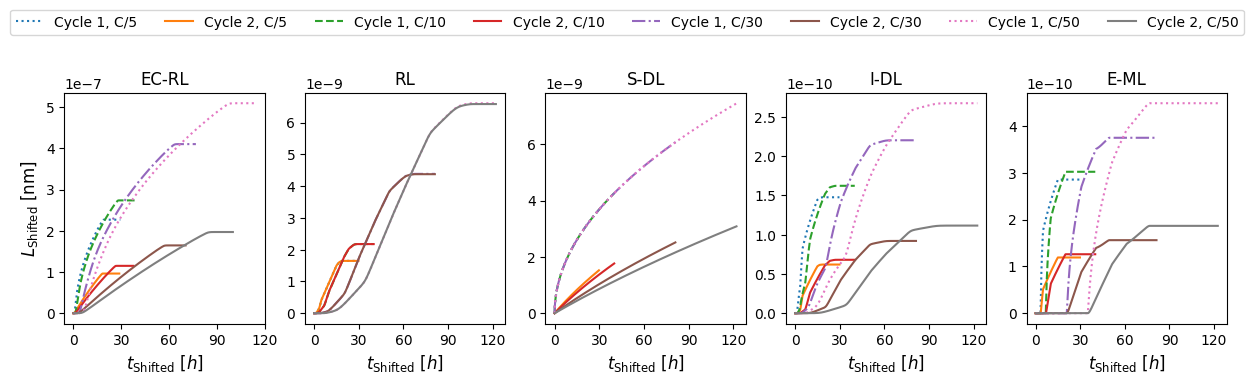

In [56]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
k = 0
line_style = [":", "-", "--", "-", "-.", "-", ":", "-",
              ":", "-", "--", "-", "-.", "-", ":", "-", "--", "-"]
marker = ["o", "x", "s", "D", "v", "p"]

for i, model in enumerate(sei_models):
    pp = 0
    for c_rate in (c_rates):
        indices = []
        for cycle in range(0, 2):
            t_min = np.min(sols[k].cycles[cycle]["Time [h]"].entries)
            L_min = np.min(
                sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries)
            t = sols[k].cycles[cycle]["Time [h]"].entries-t_min
            L_sei = (
                sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries - L_min)
            axs[i].plot(
                t, L_sei, linestyle=line_style[pp], label="Cycle " + str(cycle+1) + ", C/" + str(c_rate))
            pp += 1
        k += 1
    axs[i].set_xticks(np.linspace(0, 120, 5))  # Set x-axis ticks
    # axs[i].yaxis.set_major_formatter(ticker.FuncFormatter(
    #     lambda x, pos: '{:,.0f}'.format(x)))  # Format y-axis ticks
    axs[i].set_xlabel('$t_{\mathrm{Shifted}} \ [h]$', fontsize=12)
    axs[i].set_title(sei_models_Label[i])  # Set title for each subplot
    if i == 0:  # Only set y-label for the first subplot
        axs[i].set_ylabel(
            '$L_{\mathrm{Shifted}} \ \mathrm{[nm]} $', fontsize=12)

# Create a single legend for the whole figure from the first axes
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           ncol=len(labels), bbox_to_anchor=(0.5, 1.05))
fig.savefig('/home/kawamanmi/Projects/formation/figure2{}.svg'.format(model.capitalize()),
            format='svg', dpi=300, bbox_inches='tight')
plt.show()

Ressearch Question: At which SOC maximum amount of SEI forms?does this depends on the C-rate?


Observations:
- In EC-RL, for for C-rate C/5,  maximum SEI forms around 30% SOC wtih keeping, for other C-rates C/10,
- In RL, maximum SEI forms at maximum SOC for all C-rates
- In S-DL, maximum SEI forms at maximum SOC for all C-rates

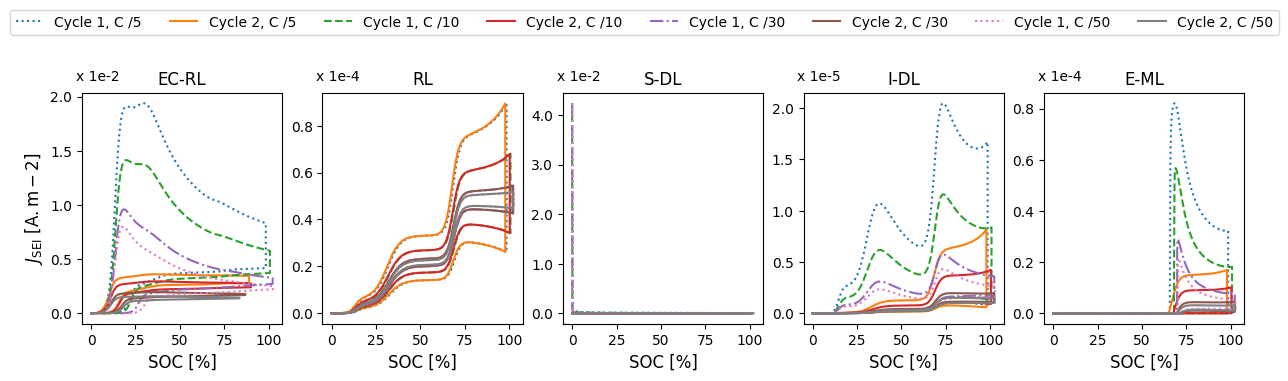

In [144]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm

fig, axs = plt.subplots(1, len(sei_models), figsize=(15, 3))
k = 0
line_style = [":", "-", "--", "-", "-.", "-", ":", "-"]

for i, model in enumerate(sei_models):
    pp = 0
    for c_rate in (c_rates):
        indices = []
        for cycle in range(0, 2):
            DCh_capacity = (
                (5 - sols[k].cycles[cycle]['Discharge capacity [A.h]'].entries)/5-1) * 100
            J_sei = np.abs(
                sols[k].cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries)
            axs[i].plot(DCh_capacity, J_sei, linestyle=line_style[pp],
                        label="Cycle " + str(cycle+1) + ", C /" + str(c_rate))
            pp += 1
        k += 1
    axs[i].set_xlabel('SOC [%]', fontsize=12)
    axs[i].set_title(sei_models_Label[i])
    current_values = axs[i].get_yticks()
    exponent = np.floor(np.log10(np.max(current_values)))
    scaled_values = current_values / 10**exponent
    axs[i].set_yticklabels(['{:.1f}'.format(y) for y in scaled_values])
    axs[i].text(-0.03, 1.1, 'x 1e{:.0f}'.format(exponent),
                transform=axs[i].transAxes, va='top', ha='left')
    if i == 0:  # Only set y-label for the first subplot
        axs[i].set_ylabel(
            '$J_{\mathrm{SEI}} \ \mathrm{[A.m-2]} $', fontsize=12)
    # Set the number of ticks on the y-axis and x-axis to 4 or 5
    axs[i].yaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[i].xaxis.set_major_locator(ticker.MaxNLocator(5))
    handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           ncol=len(labels), bbox_to_anchor=(0.5, 1.05))
fig.savefig('/home/kawamanmi/Projects/formation/figure3{}.svg'.format(model.capitalize()),
            format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
%cd /home/kawamanmi/Projects/PyBaMM
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Different set of parameters can be used in pybamm
param = pybamm.ParameterValues("Chen2020")

param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12
param[ 'Initial temperature [K]'] = 273.15

# CHarging and discharging protocol
cycle_no = 10
c_rates = [5, 10, 30, 50]
rest1 = 10
rest2 = 10
exp_CCCVs = [pybamm.Experiment(
    [("Charge at C/{} until 4.2 V".format(c_rate),
      "Rest for {} hours".format(rest1),
      "Discharge at C/{} until 2.5 V".format(c_rate),
      "Rest for {} hours".format(rest2),
      )] * cycle_no
)for c_rate in c_rates]

# SEI models in the pybamm
sei_models = ["ec reaction limited", "reaction limited",
              "solvent-diffusion limited", "interstitial-diffusion limited", "electron-migration limited"]
sei_models_Label = ["EC-RL", "RL", "S-DL", "I-DL", "E-ML"]


#Any common model DFN, SPMe, or SPM can be used the produce same results at low C-rates
models_SPM = [pybamm.lithium_ion.SPM(options={
    "SEI": sei_models[index],
     "SEI porosity change": "false",
     "thermal": "x-full"
},
    name=sei_models[index]) for index in range(len(sei_models))
]

# You may need to increase maximum number steps as follows:
pybamm.settings.max_y_value = 1000000000
solver = pybamm.CasadiSolver(mode="safe")
# solver = pybamm.IDAKLUSolver()
sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp_CCCV, solver=solver) for model in models_SPM for exp_CCCV in exp_CCCVs ]
sols = [sim.solve(initial_soc=0) for sim in sims]




/home/kawamanmi/Projects/PyBaMM


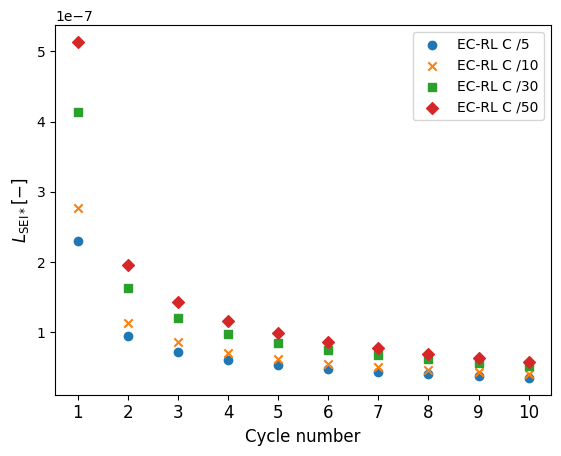

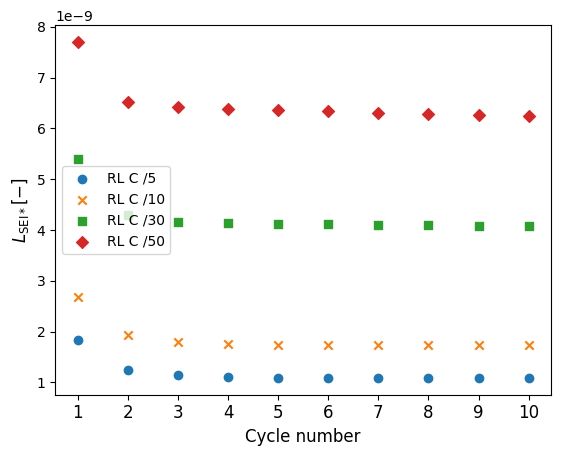

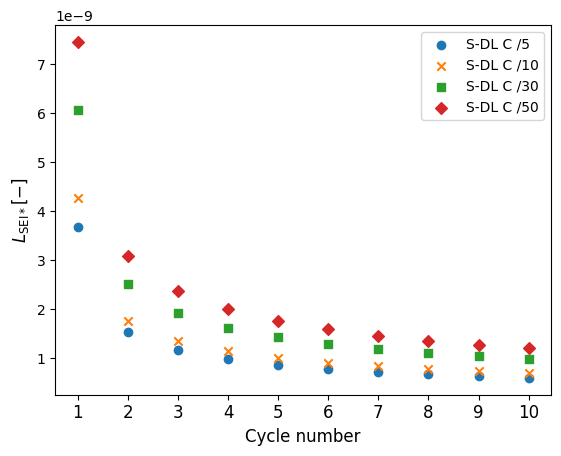

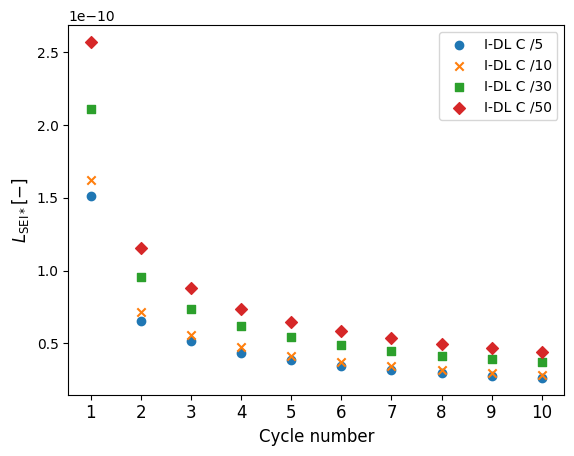

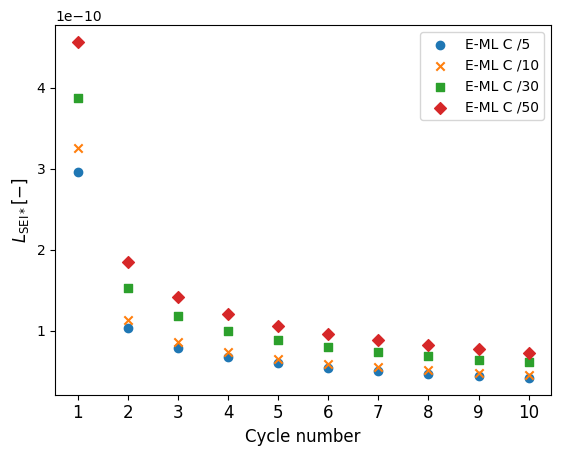

In [2]:

k = 0
line_style = ["-", ":", "--", "-.", "-", ":"]
marker = ["o", "x", "s", "D", "v", "p"]
for model in (sei_models):
    for c_rate in (c_rates):
        LL = []
        max_y = 0
        LL_max = np.max(
            sols[k]['X-averaged negative total SEI thickness [m]'].entries)
        for cycle in range(cycle_no):
            t = sols[k].cycles[cycle]["Time [h]"].entries
            L_sei = sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries
            LL.append((np.max(L_sei)-np.min(L_sei)))
        plt.scatter(np.arange(1, cycle_no+1, 1), LL, marker=marker[c_rates.index(
            c_rate)], label=sei_models_Label[sei_models.index(model)] + " C /" + str(c_rate))
        k += 1
        max_y = np.max(LL, max_y)
    plt.xticks(np.arange(1, cycle_no+1, 1), fontsize=12)
    # plt.yticks(np.round(np.linspace(round(max_y, 1), round(max_y, 1), 5), 2), fontsize=12)
    plt.xlabel("Cycle number", fontsize=12)
    plt.ylabel('$L_{\mathrm{SEI*}} [-]$', fontsize=12)
    plt.legend()
    # plt.savefig('/home/kawamanmi/Projects/formation/figure1{}.svg'.format(model.capitalize()),
    #             format='svg', dpi=300, bbox_inches='tight')
    plt.show()

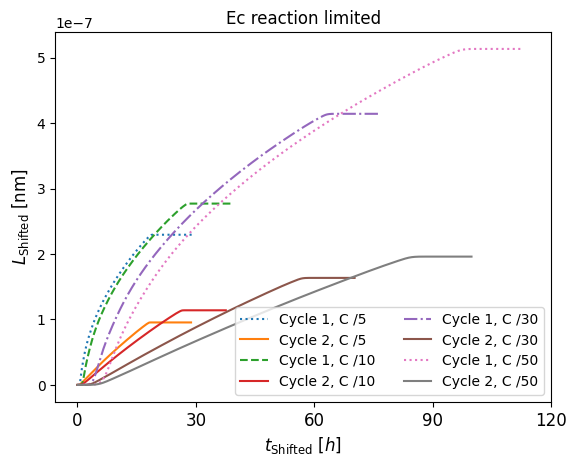

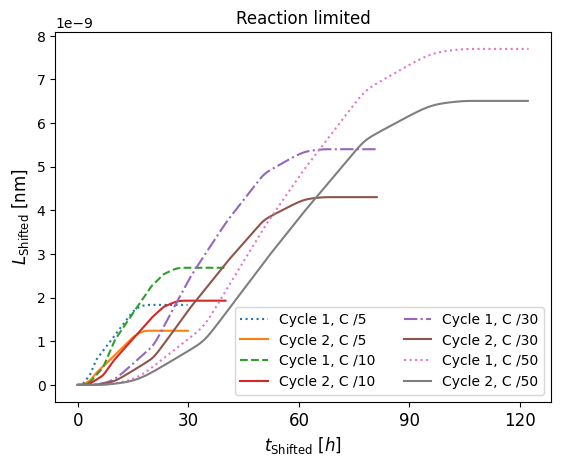

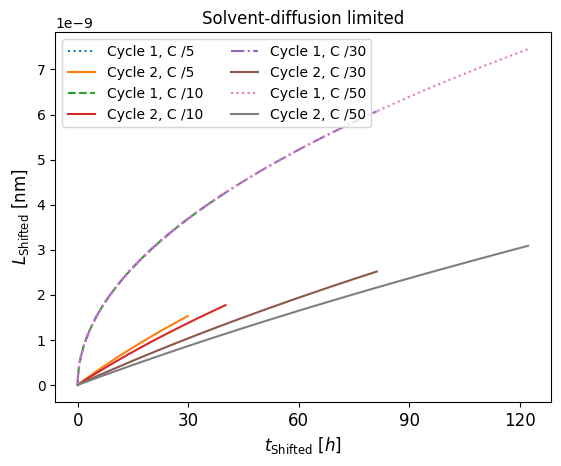

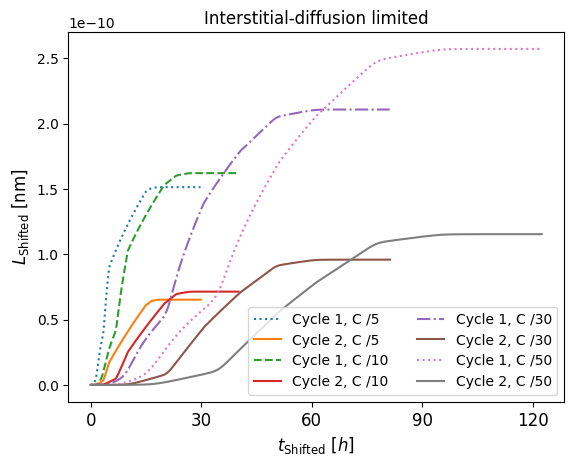

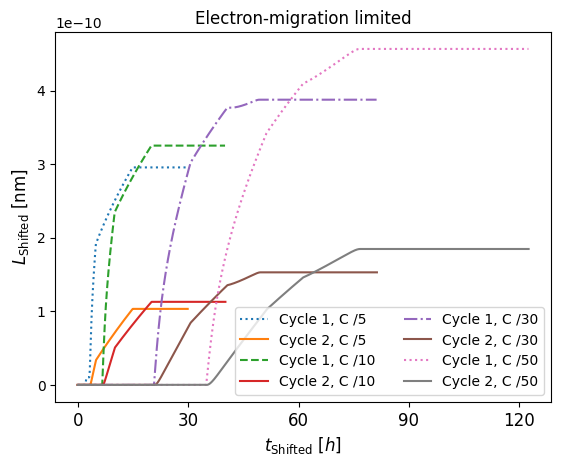

In [3]:
k = 0
line_style = [":", "-", "--", "-", "-.", "-", ":", "-",
              ":", "-", "--", "-", "-.", "-", ":", "-", "--", "-"]
marker = ["o", "x", "s", "D", "v", "p"]
plt.style.use('default')
for model in (sei_models):
    pp = 0
    for c_rate in (c_rates):
        # LL_max = np.max(
        #     sols[k]['X-averaged negative total SEI thickness [m]'].entries)
        indices = []
        for cycle in range(0, 2):
            t_min = np.min(sols[k].cycles[cycle]["Time [h]"].entries)
            L_min = np.min(
                sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries)
            # LL_max = np.max(
            #     sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries)
            t = sols[k].cycles[cycle]["Time [h]"].entries-t_min
            L_sei = (
                sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries - L_min)
            plt.plot(
                t, L_sei, linestyle=line_style[pp], label="Cycle " + str(cycle+1) + ", C /" + str(c_rate))
            pp += 1
        k += 1
    plt.xticks(np.linspace(0, 120, 5), fontsize=12)
    # plt.yticks(np.round(np.linspace(0, round(max_y, 1), 5), 2), fontsize=12)
    plt.xlabel('$t_{\mathrm{Shifted}} \ [h]$', fontsize=12)
    plt.ylabel(
        '$L_{\mathrm{Shifted}} \ \mathrm{[nm]} $', fontsize=12)
    plt.legend(ncol=2)
    plt.title(model.capitalize())
    # plt.savefig('/home/kawamanmi/Projects/formation/figure2{}.svg'.format(model.capitalize()),
    #             format='svg', dpi=300, bbox_inches='tight')
    plt.show()

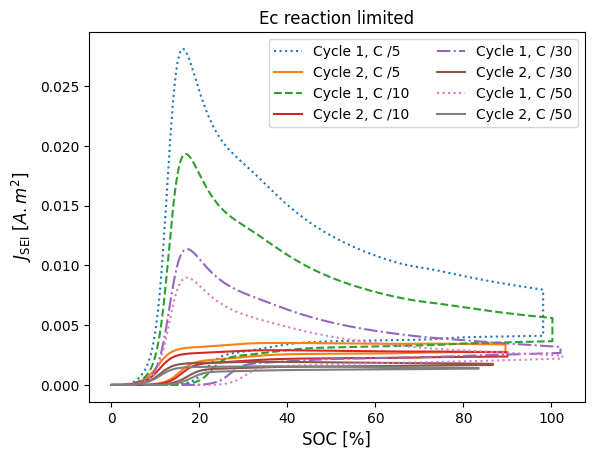

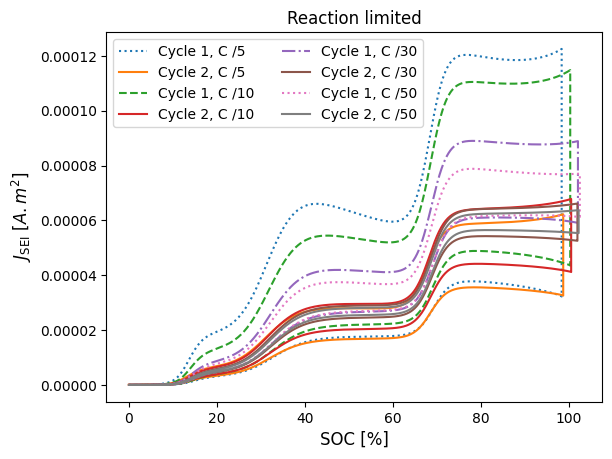

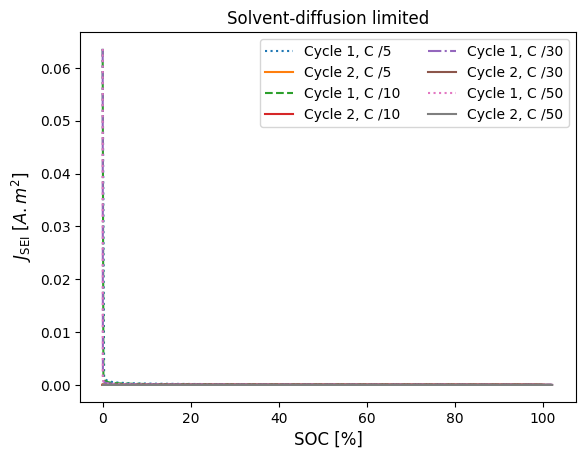

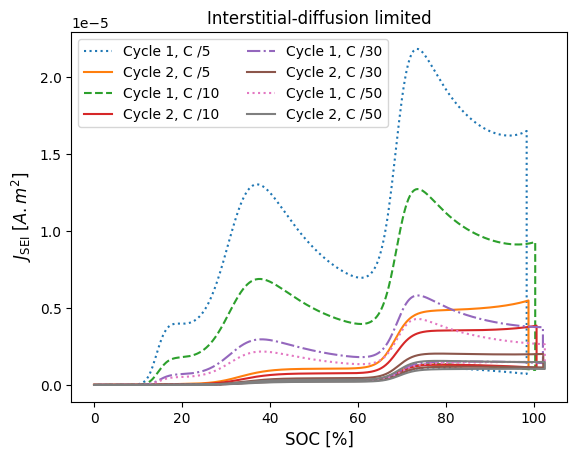

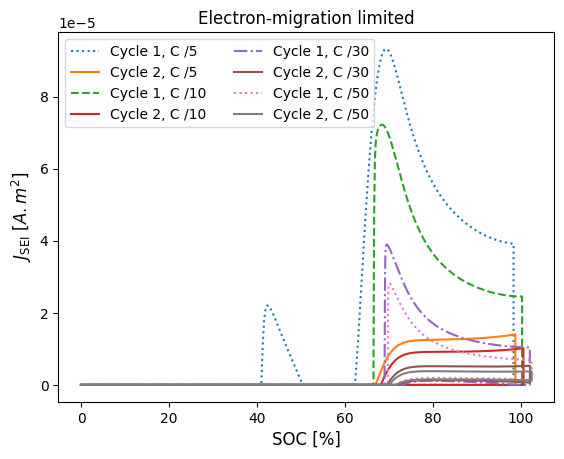

In [4]:
k = 0
line_style = [":", "-", "--", "-", "-.", "-", ":", "-"]
marker = ["o", "x", "s", "D", "v", "p"]
plt.style.use('default')
for model in (sei_models):
    pp = 0
    for c_rate in (c_rates):
        indices = []
        for cycle in range(0, 2):
            DCh_capacity = ((5 - sols[k].cycles[cycle]
                            ['Discharge capacity [A.h]'].entries)/5-1) * 100
            J_sei = np.abs(
                sols[k].cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries)
            plt.plot(
                DCh_capacity, J_sei, linestyle=line_style[pp], label="Cycle " + str(cycle+1) + ", C /" + str(c_rate))
            pp += 1
        k += 1

    # plt.xticks(np.linspace(0, 120, 5), fontsize=12)
    # plt.yticks(np.round(np.linspace(0, round(max_y, 1), 5), 2), fontsize=12)
    plt.xlabel('SOC [%]', fontsize=12)
    plt.ylabel(
        '$J_{\mathrm{SEI}} \ [A. m^2]$', fontsize=12)
    plt.legend(ncol=2)
    plt.title(model.capitalize())
    # plt.savefig('/home/kawamanmi/Projects/formation/figure3{}.svg'.format(model.capitalize()),
    #             format='svg', dpi=300, bbox_inches='tight')
    plt.show()

/home/kawamanmi/Projects/PyBaMM


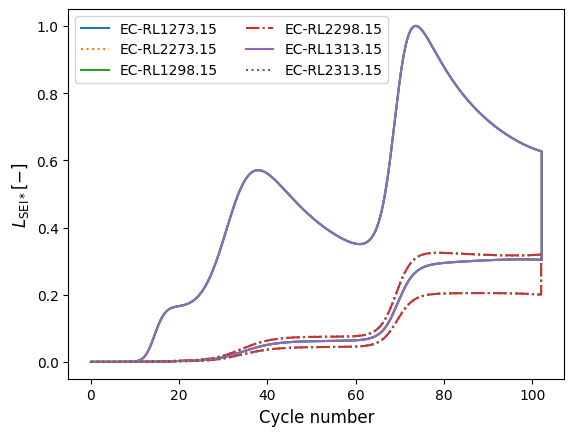

In [40]:
%cd /home/kawamanmi/Projects/PyBaMM
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Different set of parameters can be used in pybamm
params = []

param = pybamm.ParameterValues("Chen2020")
param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12
Temps  = [273.15, 298.15, 313.15]
for Temp in Temps:
    param['Initial temperature [K]'] = Temp
    param['Ambient temperature [K]'] = Temp
    params.append(param)

# CHarging and discharging protocol
cycle_no = 2
c_rates = [20]
rest1 = 10
rest2 = 10
exp_CCCVs = [pybamm.Experiment(
    [("Charge at C/{} until 4.2 V".format(c_rate),
      "Rest for {} hours".format(rest1),
      "Discharge at C/{} until 2.5 V".format(c_rate),
      "Rest for {} hours".format(rest2),
      )] * cycle_no
)for c_rate in c_rates]

# SEI models in the pybamm
sei_models = ["ec reaction limited", "reaction limited",
              "solvent-diffusion limited", "interstitial-diffusion limited", "electron-migration limited"]
sei_models = [ "interstitial-diffusion limited"]
sei_models_Label = ["EC-RL", "RL", "S-DL", "I-DL", "E-ML"]


#Any common model DFN, SPMe, or SPM can be used the produce same results at low C-rates
models_SPM = [pybamm.lithium_ion.SPM(options={
    "SEI": sei_models[index],
     "SEI porosity change": "false",
     "thermal": "x-full"
},
    name=sei_models[index]) for index in range(len(sei_models))
]

# You may need to increase maximum number steps as follows:
pybamm.settings.max_y_value = 1000000000
solver = pybamm.CasadiSolver(mode="safe")
# solver = pybamm.IDAKLUSolver()
sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp_CCCV, solver=solver) for model in models_SPM for exp_CCCV in exp_CCCVs  for param in params]
sols = [sim.solve(initial_soc=0) for sim in sims]
k = 0
pp = 0
line_style = ["-", ":", "-", "-.", "-", ":", "-", "--", "-",
              ":", "-", "--", "-", "-.", "-", ":", "-", "--", "-"]
marker = ["o", "x", "s", "D", "v", "p", ">", "<", "^", "v", "*", "h", "H", "+", "x",  "d", "|"]
for model in (sei_models):
    for c_rate in (c_rates):
        for Temp in Temps:
            J_sei_max = np.max(np.abs(
                sols[k]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries))
            for cycle in range(cycle_no):
                DCh_capacity = ((5 - sols[k].cycles[cycle]
                            ['Discharge capacity [A.h]'].entries)/5-1) * 100
                J_sei = np.abs(
                sols[k].cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries)
                plt.plot(
                DCh_capacity, J_sei/J_sei_max, linestyle=line_style[pp], label= str(sei_models_Label[sei_models.index(model)]) +str(cycle+1) + str(Temp) )
                pp += 1
            k += 1
# plt.xticks(np.arange(1, cycle_no+1, 1), fontsize=12)
        # plt.yticks(np.round(np.linspace(round(max_y, 1), round(max_y, 1), 5), 2), fontsize=12)
plt.xlabel("Cycle number", fontsize=12)
plt.ylabel('$L_{\mathrm{SEI*}} [-]$', fontsize=12)
plt.legend(ncol=2)
        # plt.title("T = " + str(Temp) + " K")
        # plt.savefig('/home/kawamanmi/Projects/formation/figure1{}.svg'.format(model.capitalize() + str(Temp)),
        #             format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Example data (replace with your actual data)
# time = np.linspace(0, 10, 100)  # Example time values
# soc = np.linspace(0, 100, 50)  # Example SOC values
# jsei = np.random.rand(len(soc), len(time))  # Example Jsei values
# c_rates = [5, 10, 30]  # Example C-rate values

# # Create contour plot
# fig, axs = plt.subplots(1, len(c_rates), figsize=(15, 5))

# for i, c_rate in enumerate(c_rates):
#     ax = axs[i]
#     contour = ax.contourf(time, soc, jsei, cmap='viridis')
#     ax.set_title(f'C-rate = {c_rate}')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('SOC')
#     fig.colorbar(contour, ax=ax, label='Jsei')

# plt.tight_layout()
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Example data (replace this with your actual data)
# # Assuming 11 SOC values from 0 to 100
# soc_values = np.linspace(0, 100, num=11)
# cycle_numbers = [1, 2, 3, 4, 5]  # Cycle numbers
# sei_values = np.random.rand(len(cycle_numbers), len(
#     soc_values)) * 0.5  # Example SEI values

# # Create a meshgrid for SOC and cycle numbers
# X, Y = np.meshgrid(soc_values, cycle_numbers)

# # Create the contour plot
# contour = plt.contourf(X, Y, sei_values, cmap='viridis',
#                        levels=np.linspace(0, 0.5, 11))
# cbar = plt.colorbar(contour)
# cbar.set_label('SEI Value')
# plt.xlabel('State of Charge (%)')
# plt.ylabel('Cycle Number')
# plt.title('SEI Contour Plot')
# plt.show()

In [ ]:

# This part for plot vertical lines to distngush charge and discharge per
# current = sols[k].cycles[cycle]['Current [A]'].entries
# indices = np.where(current[:-1] != current[1:])[0]
# # Add the last index if the last element is different from the previous one
# if current[-1] != current[-2]:
#     indices = np.append(indices, len(current) - 1)
# for i in indices:
#     plt.plot([t[i]/np.max(t), t[i]/np.max(t)], [0, np.max(L_sei)])

In [ ]:
# k = 0
# line_style = ["-", ":", "--", "-.", "-", ":"]
# marker = ["o", "x", "s", "D", "v", "p"]
# for model in (sei_models):
#     for c_rate in (c_rates):
#         LL = []
#         max_y = 0
#         min_y = 1
#         LL_max = np.max(
#             sols[k]['X-averaged negative total SEI thickness [m]'].entries)
#         # for cycle in range(cycle_no):
#         t = sols[k].cycles[1]["Time [h]"].entries
#         L_sei = sols[k].cycles[1]['X-averaged negative total SEI thickness [m]'].entries/LL_max
#         LL.append((np.max(L_sei)-np.min(L_sei)))
#         plt.plot(t/np.max(t), L_sei, linestyle=line_style[c_rates.index(
#             c_rate)], label=model.capitalize() + " C /" + str(c_rate))
#         k += 1
#         # max_y = np.max(LL, max_y)
#         # min_y = np.min(LL, min_y)
#     # plt.xticks(np.linspace(0, 1, 5), fontsize=12)
#     # plt.yticks(np.round(np.linspace(round(min_y, 1),
#     #            round(max_y, 1), 5), 2), fontsize=12)
#     plt.xlabel('$t_* \ [-]$', fontsize=12)
#     plt.ylabel('$L_{\mathrm{SEI*}} \ [-]$', fontsize=12)
#     plt.legend()
#     # plt.savefig('/home/kawamanmi/Projects/formation/Modval2024/figure{}.svg'.format(model.capitalize()),
#     #             format='svg', dpi=300, bbox_inches='tight')
#     plt.show()
#     t_max = np.max(sols[1].cycles[1]["Time [h]"].entries)
#     ch = sols[1].cycles[1]['Total current density [A.m-2]'].entries < 0
#     t_ch = np.max(sols[1].cycles[1]["Time [h]"].entries[ch])
#     d_ch = sols[1].cycles[1]['Total current density [A.m-2]'].entries > 0
#     t_dch = np.min(sols[1].cycles[1]["Time [h]"].entries[d_ch])
#     # print(np.max(t_ch)/t_max, np.min(t_dch)/t_max)
# plt.plot(sols[1].cycles[1]["Time [h]"].entries/t_max, sols[1].cycles[1]
#          ['Total current density [A.m-2]'].entries)
# plt.plot([t])

In [ ]:
# # Vaiables to be postprocessed, you can add as many as output variables to the following list
# # you can find the list variables to be be output by typing model name dot varaible_name() e.g. here, models[0].variable_names()
# out_vars = [  # 'X-averaged negative particle surface concentration [mol.m-3]',
#     # "Voltage [V]",
#     # 'X-averaged negative SEI thickness [m]',
#     'Discharge capacity [A.h]'
#     # 'Total capacity lost to side reactions [A.h]',
#     # 'Loss of lithium to SEI [mol]',
#     'Total current density [A.m-2]',
#     # 'X-averaged outer SEI thickness [m]',
#     # 'X-averaged negative electrode porosity',
# ]

# # Label for the output variables y-axis in the plots
# yaxis_labels = ["SEI_thickness",
#                 'Total capacity lost to side reactions [A.h]', 'Total lithium in particles', 'X-averaged inner SEI thickness [m]',
#                 'X-averaged outer SEI thickness [m]',]

In [ ]:
# from matplotlib import lines

# for sol in sols_SPM:  # loop through the solutions of the DFN models
#     LS_cycles = [sol.cycles[k].steps[2]['X-averaged SEI thickness [m]'].entries[-1]
#                  for k in range(cycle_no)]
#     plt.scatter(np.arange(1, cycle_no+1), LS_cycles,
#                 label=models_SPM[sols_SPM.index(sol)].name)
# plt.xlabel("Cycle number")
# plt.ylabel("SEI thickness [m]")
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(sols_SPM[0].t, sols_SPM[0]
#          ['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries)
# plt.show()
# dd = len(sei_models)
# print(dd)
# for j in range(dd):
#     plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#              ['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries, label=models_SPM[j].name)
# plt.legend()
# plt.show()

# for j in range(dd):
#     if (j == dd):
#         plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#                  ['X-averaged negative electrode SEI film overpotential [V]'].entries, label=models_SPM[j].name)
#     else:
#         plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#                  ['X-averaged negative electrode SEI film overpotential [V]'].entries, label=models_SPM[j].name)
# plt.legend()
# plt.show()

# for j in range(dd):
#     # if (j == dd-2):
#     #     plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#     #              ['X-averaged negative total SEI thickness [m]'].entries, label=models_SPM[j].name + "/100")
#     # else:
#     L_sei_max = sols_SPM[j]['X-averaged negative total SEI thickness [m]'].entries.max()
#     plt.plot(sols_SPM[j].t/3600, sols_SPM[j]
#              ['X-averaged negative total SEI thickness [m]'].entries/L_sei_max, label=models_SPM[j].name)
# plt.xlabel("Time [h]")
# plt.ylabel("SEI thickness [nm]")
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(sols_SPM[5].t/3600, sols_SPM[5]
#          ['X-averaged negative total SEI thickness [m]'].entries)

In [ ]:


# for j in range(cycle_no):
#     for sol in sols_SPM:  # loop through the solutions of the DFN models
#         total_capacity_lost = sol.cycles[j]['Total capacity lost to side reactions [A.h]'].entries
#         L_sei = sol.cycles[j]['X-averaged negative total SEI thickness [m]'].entries
#         # print(L_sei[-1] - L_sei[0])
#         plt.plot(sol.cycles[j]["Time [h]"].entries, total_capacity_lost,
#                  label=sei_models[sols_SPM.index(sol)] + "Cycle " + str(j+1))
# plt.xlabel("Time [h]")
# plt.ylabel("Capacity lost [A.h]")
# plt.legend()
# # plt.title("Cycle " + sei_models[sols_SPM.index(sol)])
# plt.show()

In [ ]:


# line_style = ["-", ":", "--", "-.", "-", ":"]
# LL_SEIs = []
# Dcs = []
# for sol in sols_SPM:  # loop through the solutions of the DFN models
#     for j in range(cycle_no):
#         negative_current_indices = sol.cycles[j]['Current [A]'].entries > 0
#         SoC = sol.cycles[j]['Throughput capacity [A.h]'].entries[negative_current_indices]
#         vol = sol.cycles[j]["Voltage [V]"].entries[negative_current_indices]
#         L_sei = sol.cycles[j]['X-averaged negative total SEI thickness [m]'].entries
#         LL_SEIs.append(L_sei[-1] - L_sei[0])
#         Dc = sol.cycles[j]['Discharge capacity [A.h]'].entries
#         Dcs.append((SoC[-1]-SoC[0])/5*100)
#         # negative_current_indices = sol.cycles[j]['Current [A]'].entries < 0
#         # SoC = sol.cycles[j]['Discharge capacity [A.h]'].entries[negative_current_indices]
#         # vol = sol.cycles[j]["Voltage [V]"].entries[negative_current_indices]
#         plt.plot(SoC-SoC[0], vol,
#                  label=sei_models[sols_SPM.index(sol)] + " cycle " + str(j+1), linestyle=line_style[j])
# plt.xlabel('Throughput capacity [A.h]', fontsize=14)
# plt.ylabel("Voltage [V]", fontsize=14)
# # plt.legend()
# # plt.title("Cycle " + sei_models[sols_SPM.index(sol)])
# plt.show()

In [ ]:


# kk = 0
# marker = ["o", "x", "s", "D", "v", "p"]
# # Create a list of distinct colors
# colors = plt.cm.plasma(np.linspace(0, 1, len(sols_SPM)))

# jj = np.arange(1, cycle_no + 1)
# k1 = 0
# k2 = len(jj)

# for idx, sol in enumerate(sols_SPM):
#     # Check if it's the last sol
#     capitalized_label = sei_models[sols_SPM.index(sol)].title()
#     L_max = np.array(LL_SEIs[k1:k2]).max()
#     if idx == 0:
#         plt.scatter(jj, np.array(LL_SEIs[k1:k2]) / 100 * 1e9,
#                     label=capitalized_label + " / 100",
#                     marker=marker[sols_SPM.index(sol)],
#                     color=colors[sols_SPM.index(sol)])
#     elif idx == len(sols_SPM)-2 or idx == len(sols_SPM)-1:
#         plt.scatter(jj, np.array(LL_SEIs[k1:k2])*10 * 1e9,
#                     label=capitalized_label + " x 10",
#                     marker=marker[sols_SPM.index(sol)],
#                     color=colors[sols_SPM.index(sol)])
#     else:
#         plt.scatter(jj, np.array(LL_SEIs[k1:k2]) * 1e9,
#                     label=capitalized_label,
#                     marker=marker[sols_SPM.index(sol)],
#                     color=colors[sols_SPM.index(sol)])


# for idx, sol in enumerate(sols_SPM):
#     # Check if it's the last sol
#     capitalized_label = sei_models[sols_SPM.index(sol)].title()
#     L_max = np.array(LL_SEIs[k1:k2]).max()
#     plt.scatter(jj, np.array(LL_SEIs[k1:k2]) / L_max,
#                 label=capitalized_label,
#                 marker=marker[sols_SPM.index(sol)],
#                 color=colors[sols_SPM.index(sol)])

#     k1 = k1 + cycle_no
#     k2 = k2 + cycle_no

# # Add a legend to the plot
# plt.legend(fontsize=12)
# plt.ylabel("Increment Length SEI [nm]", fontsize=12)
# plt.xlabel("Cycle Number", fontsize=12)
# plt.xticks(np.arange(1, cycle_no+1, 1), fontsize=12)
# plt.yticks(np.arange(0, 1.01, 0.2), fontsize=12)
# # plt.savefig('/home/kawamanmi/Projects/figure.svg',
# #             format='svg', dpi=300, bbox_inches='tight')
# plt.show()


# jj = np.arange(1, cycle_no + 1)
# k1 = 0
# k2 = len(jj)

# for idx, sol in enumerate(sols_SPM):
#     # Check if it's the last sol
#     capitalized_label = sei_models[sols_SPM.index(sol)].title()
#     if idx == 0:
#         plt.scatter((100-np.array(Dcs[k1:k2]))-10, np.array(LL_SEIs[k1:k2])/1 * 1e9,
#                     label=capitalized_label + " x 10",
#                     marker=marker[sols_SPM.index(sol)],
#                     color=colors[sols_SPM.index(sol)])
#     elif idx == len(sols_SPM)-2 or idx == len(sols_SPM)-1:
#         plt.scatter(100-np.array(Dcs[k1:k2]), np.array(LL_SEIs[k1:k2]) * 1e9,
#                     label=capitalized_label + " x 10",
#                     marker=marker[sols_SPM.index(sol)],
#                     color=colors[sols_SPM.index(sol)])
#     else:
#         plt.scatter(100 - np.array(Dcs[k1:k2]), np.array(LL_SEIs[k1:k2]) * 1e9,
#                     label=capitalized_label,
#                     marker=marker[sols_SPM.index(sol)],
#                     color=colors[sols_SPM.index(sol)])

#     k1 = k1 + cycle_no
#     k2 = k2 + cycle_no
#     plt.legend()
# plt.ylabel("Increment Length SEI [nm]", fontsize=14)
# plt.xlabel("Cycle Number")
# plt.xticks(np.arange(1, cycle_no+1, 1))
# plt.yticks(np.arange(0, 5, 1))
# plt.show()
# print(Dcs)

In [ ]:
# # import matplotlib.pyplot as plt
# # import numpy as np

# # # Create a figure and axis for the main plot
# fig, ax_main = plt.subplots()

# # # Loop through cycles and solutions
# for sol in sols_SPM:
#     for j in range(cycle_no):
#         negative_current_indices = sol.cycles[j]['Current [A]'].entries > 0
#         SoC = sol.cycles[j]['Discharge capacity [A.h]'].entries[negative_current_indices]
#         vol = sol.cycles[j]["Voltage [V]"].entries[negative_current_indices]
#         print(np.abs(SoC[0]) / 5 * 100)
#         ax_main.plot(np.abs(SoC) / 5 * 100, vol,
#                      label=sei_models[sols_SPM.index(sol)] + " cycle " + str(j + 1))

# # Set labels and legend for the main plot
# ax_main.set_xlabel("SOC [%]")
# ax_main.set_ylabel("Voltage [V]")
# ax_main.legend()

# # Create a subplot for magnification
# # Adjust the coordinates and size as needed
# ax_magnify = plt.axes([0.2, 0.6, 0.25, 0.25])

# # Plot the magnified section (voltage between 2.5 and 2.75)

# for sol in sols_SPM:
#     for j in range(cycle_no):
#         negative_current_indices = sol.cycles[j]['Current [A]'].entries < 0
#         SoC = sol.cycles[j]['Discharge capacity [A.h]'].entries[negative_current_indices]
#         vol = sol.cycles[j]["Voltage [V]"].entries[negative_current_indices]

#         # Only plot the desired voltage range in the magnified subplot
#         voltage_range_mask = (vol >= 2.5) & (vol <= 2.75)
#         ax_magnify.plot(np.abs(SoC[voltage_range_mask]) /
#                         5 * 100, vol[voltage_range_mask])

# # Set labels for the magnified subplot
# ax_magnify.set_xlabel("SOC [%]")
# ax_magnify.set_ylabel("Voltage [V]")
# ax_magnify.set_title("Magnified View (Voltage between 2.5 and 2.75)")

# # Show the plots
# plt.show()

In [ ]:
# from matplotlib import lines


# for out_var in out_vars:  # Loop through the output variables
#     for sol in sols_SPM:  # loop through the solutions of the SPM models
#         plt.plot(sol['Time [h]'].entries, sol[out_var].entries,
#                  linestyle='--',
#                  label=models_SPM[sols_SPM.index(sol)].name)

#     plt.xlabel("Time [h]")
#     plt.ylabel(yaxis_labels[out_vars.index(out_var)])
#     plt.legend()
#     plt.show()